# Aggregating manual annotations and correlations

We read the evaluation results from excel files that have the following columns:

Turn	
Speaker	
Cue	
Response	
Context

System ratings
* MLM response	
* System llh	
* MLM llh	
* USR DLcontext	
* USR DLfact	

Human ratings:
* Overall Human Rating	
* Interesting	
* Engaging	
* Specific	
* Relevant	
* Correct	
* Semantically Appropriate	
* Understandable	
* Fluent

In [1]:
# Needed to calculate the mean square error for regression scores
#! pip install sklearn

In [2]:
### Needed to read Ecel files: xlsx
# ! pip install openpyxl

In [47]:
from pathlib import Path
import glob
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt

#group = "g1-piek"
group = "g2-jaap"
#group = "g3-lea"
#group = "g4-tae"
annotation_path = "/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/"+group+"/scenario2"
#annotation_path = "."
basepath = Path(annotation_path)

In [76]:
def get_score_triples_from_turn(json_row:str, speaker_scores:{}, auto_score:str, hum_score:str):
    speaker = json_row['Speaker']
    turn = json_row['Turn']
    auto = json_row[auto_score]
    hum = json_row[hum_score]
    triple = (turn, auto, hum)
    if not speaker_scores.get(speaker):
        speaker_scores[speaker]=[]
    speaker_scores[speaker].append(triple)
    
def evaluate_regression_scores(basepath:Path, speaker_scores:{},auto_score:str, hum_score:str):
    turn_index =[]
    speaker_scores:{}
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            get_score_triples_from_turn(turn, speaker_scores, auto_score,hum_score)

def get_scores_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        if not turn_scores.get(turn):
            turn_scores[turn]=[]
        turn_scores[turn].append(score)

def get_score_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        turn_scores[turn]= score

def get_normalized_human_scores(basepath:Path, score_name:str):
    all_turn_scores = {}
    normalized_scores = {}
    averaged_score = []
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        if 'Turn' in df:
            print(path)
            js = df.to_json(orient = 'records')
            turn_scores={}
            for turn in json.loads(js):
                get_scores_for_turns(turn, turn_scores, score_name)
            for turn_id in turn_scores:
                if not all_turn_scores.get(turn_id):
                    all_turn_scores[turn_id]=[]
                all_turn_scores[turn_id].extend(turn_scores[turn_id])

    for turn_id in all_turn_scores:
        scores = all_turn_scores[turn_id]
        average = sum(scores)/len(scores)
        averaged_score.append(average)
        normalized_score = (average-1)/4
        normalized_scores[turn_id]=normalized_score
    averaged_score = sum(averaged_score)/len(averaged_score)
    #print(normalized_scores)
    #print(averaged_score)
    return normalized_scores, averaged_score

## Averaging the human annotations 

In [77]:
score_name = "Overall Human Rating"
normalized_scores_overall, average_overall = get_normalized_human_scores(basepath, score_name)

score_name = "Interesting"
normalized_scores_interesting, average_interesting = get_normalized_human_scores(basepath, score_name)

score_name = "Engaging"
normalized_scores_engaging, average_engaging = get_normalized_human_scores(basepath, score_name)

score_name = "Specific"
normalized_scores_specific, average_specific = get_normalized_human_scores(basepath, score_name)

score_name = "Relevant"
normalized_scores_relevant, average_relevant = get_normalized_human_scores(basepath, score_name)

score_name = "Correct"
normalized_scores_correct, average_correct = get_normalized_human_scores(basepath, score_name)

score_name = "Semantically Appropriate"
normalized_scores_semantic, average_semantic = get_normalized_human_scores(basepath, score_name)

score_name = "Understandable"
normalized_scores_understandable, average_understand = get_normalized_human_scores(basepath, score_name)

score_name = "Fluent"
normalized_scores_fluent, average_fluent = get_normalized_human_scores(basepath, score_name)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Piotr scenario 2.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Ella scenario 2b.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Piotr scenario 2.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Ella scenario 2b.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Piotr scenario 2.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Ella scenario 2b.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Piotr scenario 2.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Ella scenario 2b.csv
/Users/piek/Desktop/t-MA-Combots-2021/ev

In [78]:
print(average_overall)
print(average_interesting)
print(average_engaging)
print(average_specific)
print(average_relevant)
print(average_correct)
print(average_semantic)
print(average_understand)
print(average_fluent)

2.3541666666666665
1.5625
1.9166666666666667
2.0208333333333335
2.8333333333333335
2.625
2.4375
3.3333333333333335
2.6666666666666665


### Visualising the human ratings over turns

In [52]:
def extend__with_bar(width, normalized_scores:{}, score_name:str, plt, colors:[], used_colors):
    turns = list(normalized_scores.keys())
    ###We take all turns from the turn_index to create the x-axis
    x = np.arange(len(turns))
    y = []
    for key in normalized_scores:
        y.append(normalized_scores[key])
    c1 = choice(colors)   
    while c1 in used_colors:
        c1 = choice(colors)
    
    used_colors.append(c1)
    plt.barh(x+width, y,  color=c1, edgecolor="black", label=score_name, height=0.1)
    #plt.bar(x+width, y,  color=c1, width=barWidth, edgecolor="black", label=score_name)

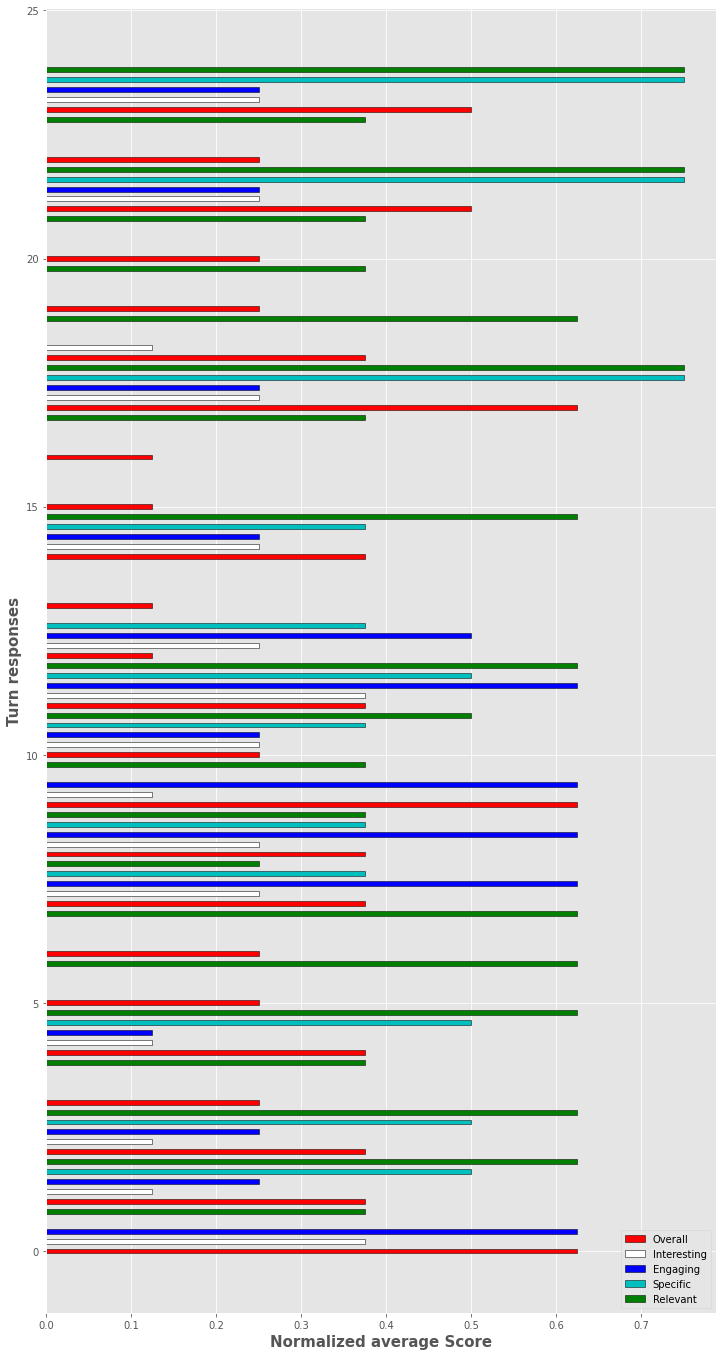

In [53]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

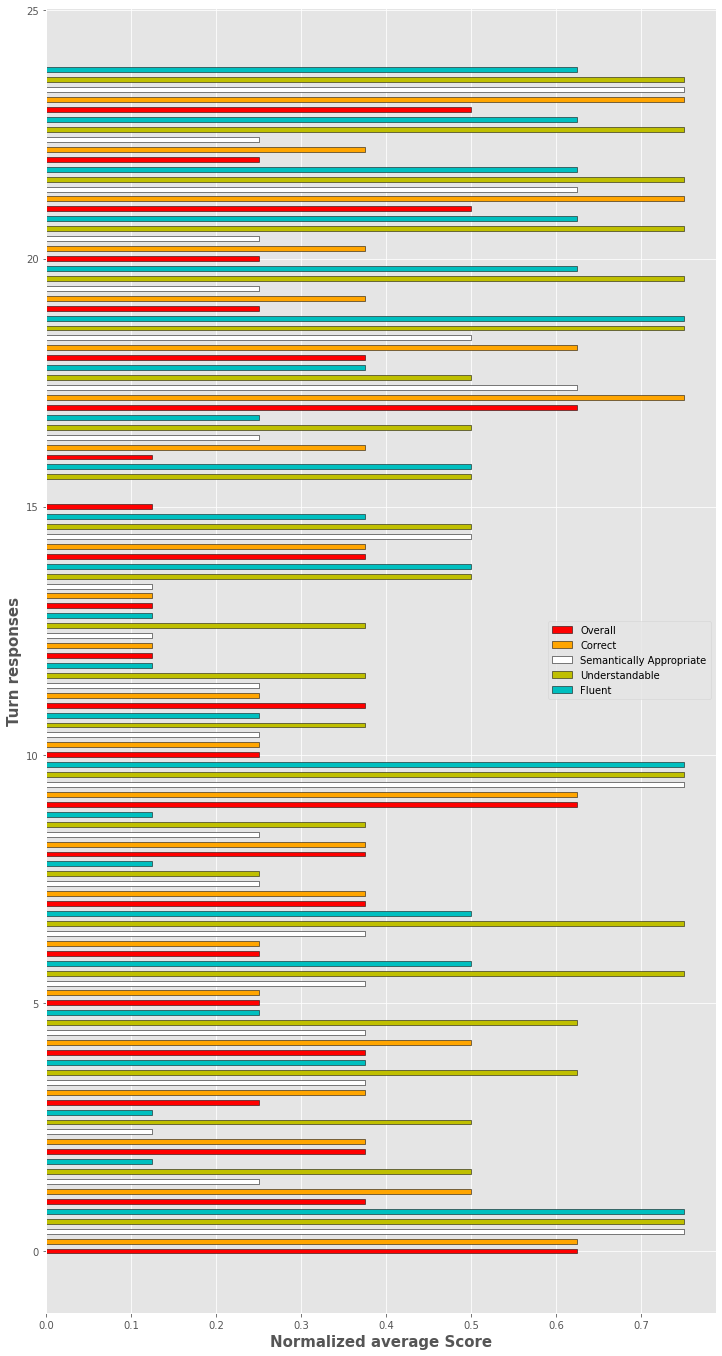

In [54]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

### Correlating the human annotations with overall rating

In [55]:
#https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_mean_error_area(scores_x, scores_y):
    x = []
    for key in scores_x:
        x.append(scores_x[key])
    y = []
    for key in scores_y:
        y.append(scores_y[key])

    dif=(len(x)-len(y))
    if dif>0:
        for i in range(dif):
            y.append(0)
    if dif<0:
        for i in range(dif*-1):
            x.append(0)
            
    #print(score_name_x, "&", score_name_y)
    mae = mean_absolute_error(x, y).round(2)
    mse = mean_squared_error(x, y).round(2)
    rmse = mean_squared_error(x, y, squared=False).round(2)
    #print(f"Mean Absolute Error:", mae)
    #print(f"Mean Squared Error:", mse)
    #print(f"Root Mean Squared Error:", rmse)
    return mae, mse, rmse

In [56]:
rows = []
score_name_x = "Overall Human Rating"

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_interesting)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_relevant)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_correct)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_semantic)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_understandable)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_fluent)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_scores = pd.DataFrame(rows)
df_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_scores.to_csv(file, index=False)

## Correlating automated score with the human ratings

### System likelihood of the agent answers

In [57]:
score_name_x = "System llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files


for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Piotr scenario 2.csv
24 {4: 0.5622974746, 6: 0.3742135258, 8: 0.4922878082, 10: 0.4184157496, 12: 0.5240155682, 14: 0.4736407598, 16: 0.3079043031, 18: 0.3567689161, 20: 0.4199408188, 25: 0.366120827, 27: 0.4856465124, 29: 0.4737460718, 31: 0.3353824119, 33: 0.0364302124, 35: 0.5666718524, 37: 0.242956418, 39: 0.4179319335, 41: 0.4068383524, 43: 0.6526022553, 45: 0.2592780193, 47: 0.4748911063, 49: 0.3884248709, 51: 0.6443493664, 53: 0.7780006698}
24 {4: 0.625, 6: 0.375, 8: 0.375, 10: 0.25, 12: 0.375, 14: 0.25, 16: 0.25, 18: 0.375, 20: 0.375, 25: 0.625, 27: 0.25, 29: 0.375, 31: 0.125, 33: 0.125, 35: 0.375, 37: 0.125, 39: 0.125, 41: 0.625, 43: 0.375, 45: 0.25, 47: 0.25, 49: 0.5, 51: 0.25, 53: 0.5}


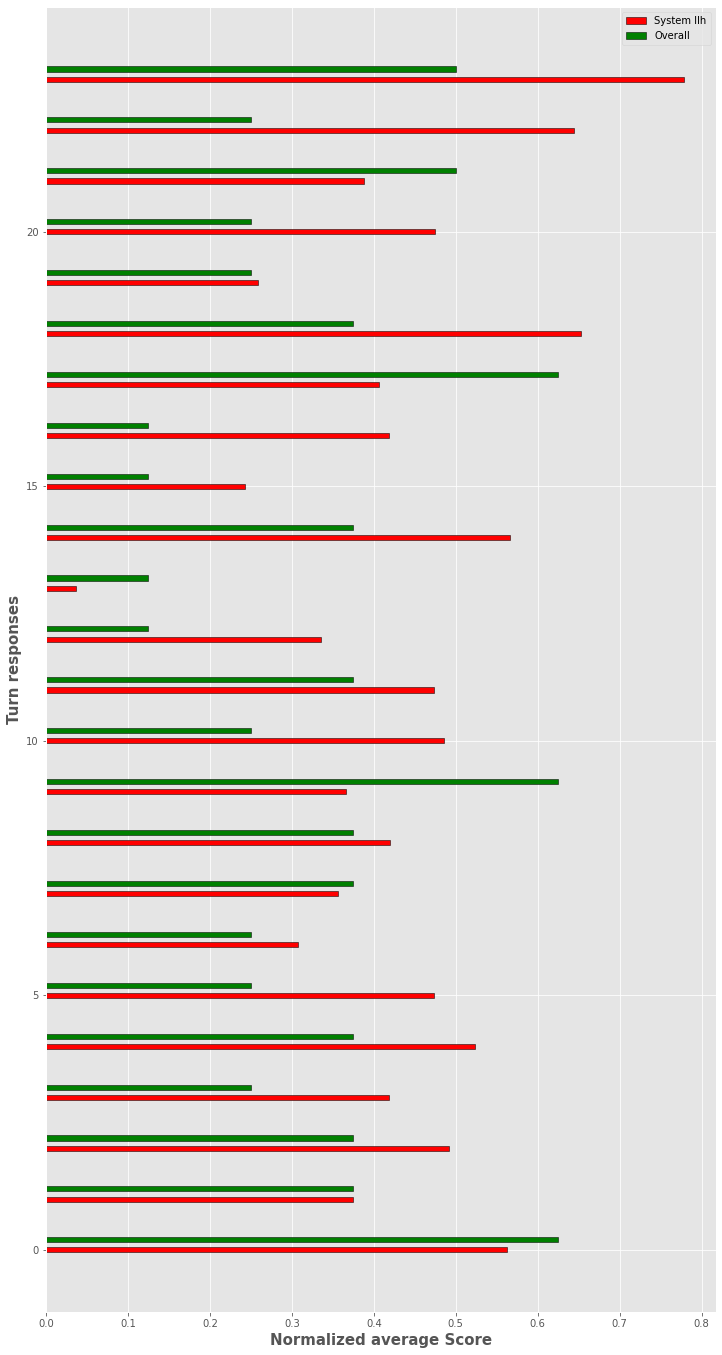

In [58]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()


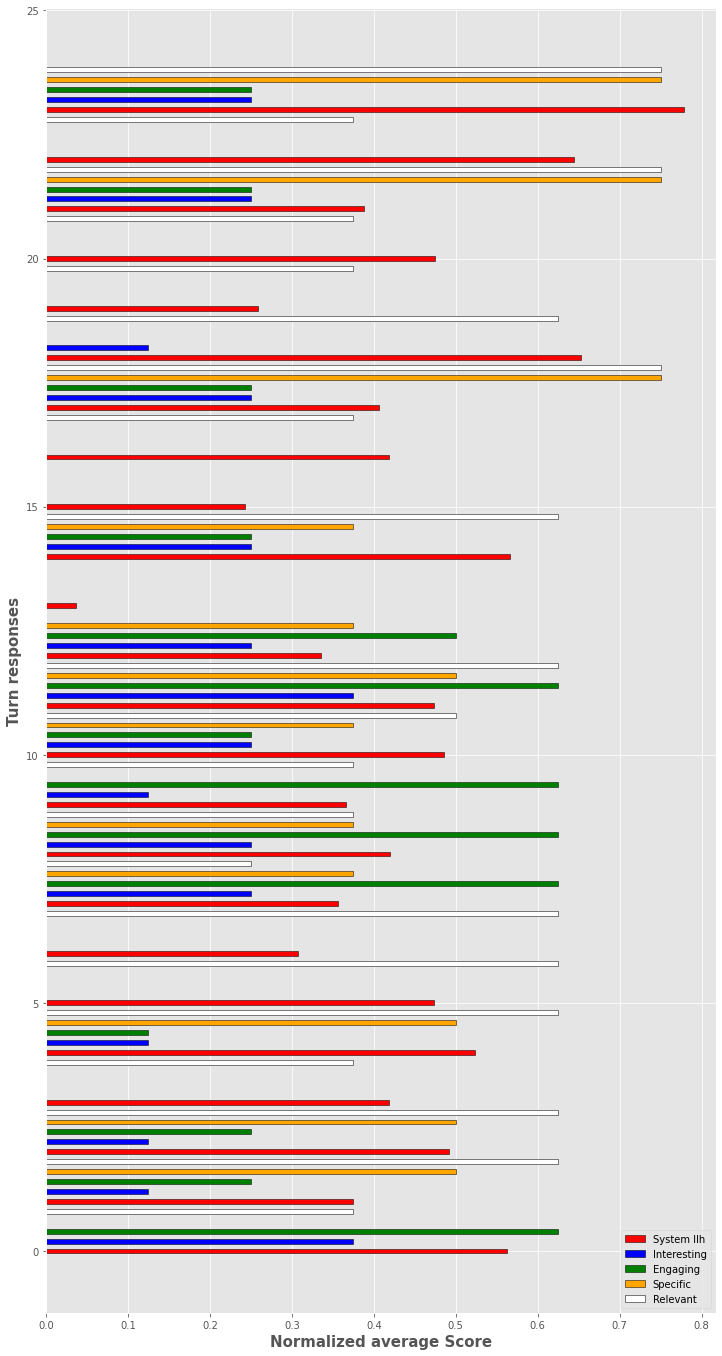

In [59]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)


score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)


plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()



In [60]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})



df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### MLM likelihood of the language model

In [61]:
score_name_x = "MLM llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

# Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)


/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Piotr scenario 2.csv
24 {4: 0.7624528383, 6: 0.6498549603, 8: 0.6584571284, 10: 0.5370548286, 12: 0.6303417996, 14: 0.6470643083, 16: 0.5354201198, 18: 0.5930947661, 20: 0.6897992209, 25: 0.4578738968, 27: 0.6762102072, 29: 0.6372977942, 31: 0.5312667725, 33: 0.3590555365, 35: 0.7594760602, 37: 0.5027751837, 39: 0.6727110041, 41: 0.6218079261, 43: 0.8600826412, 45: 0.5722168883, 47: 0.5717181762, 49: 0.4659072806, 51: 0.8788399547, 53: 0.7982858398}
24 {4: 0.625, 6: 0.375, 8: 0.375, 10: 0.25, 12: 0.375, 14: 0.25, 16: 0.25, 18: 0.375, 20: 0.375, 25: 0.625, 27: 0.25, 29: 0.375, 31: 0.125, 33: 0.125, 35: 0.375, 37: 0.125, 39: 0.125, 41: 0.625, 43: 0.375, 45: 0.25, 47: 0.25, 49: 0.5, 51: 0.25, 53: 0.5}


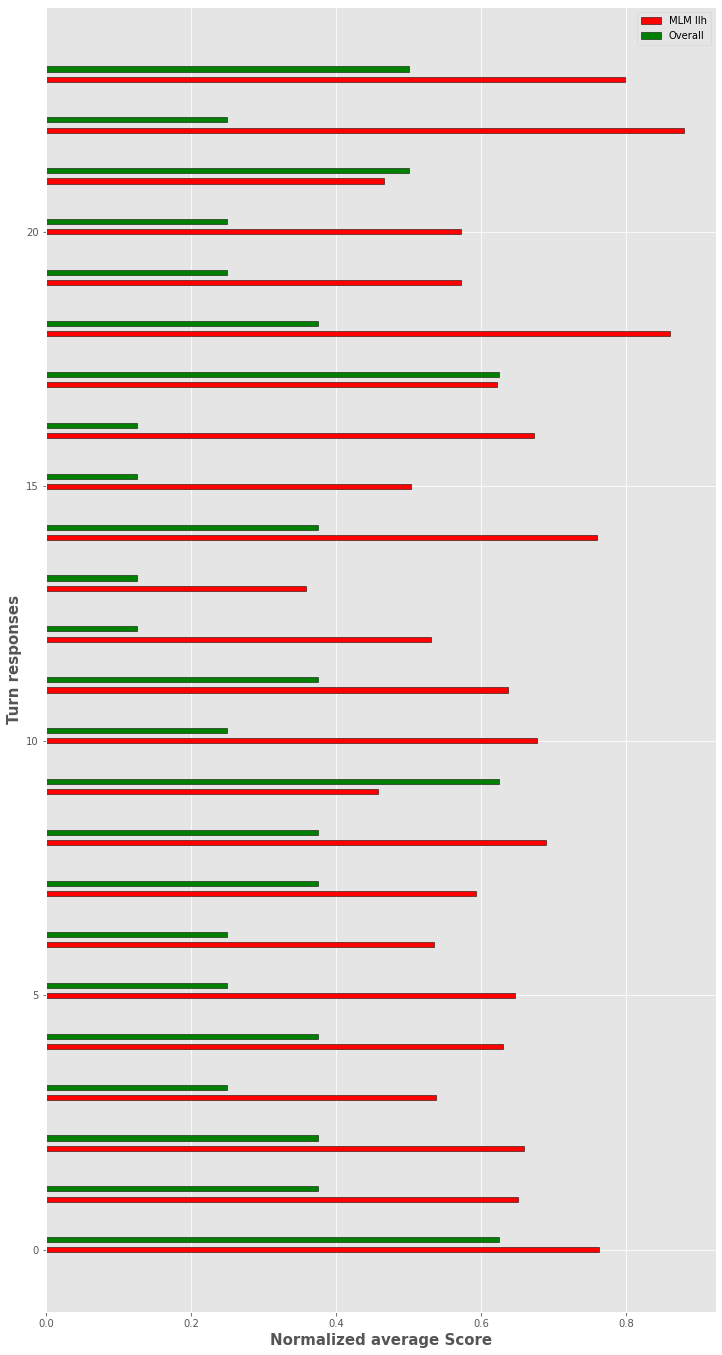

In [62]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

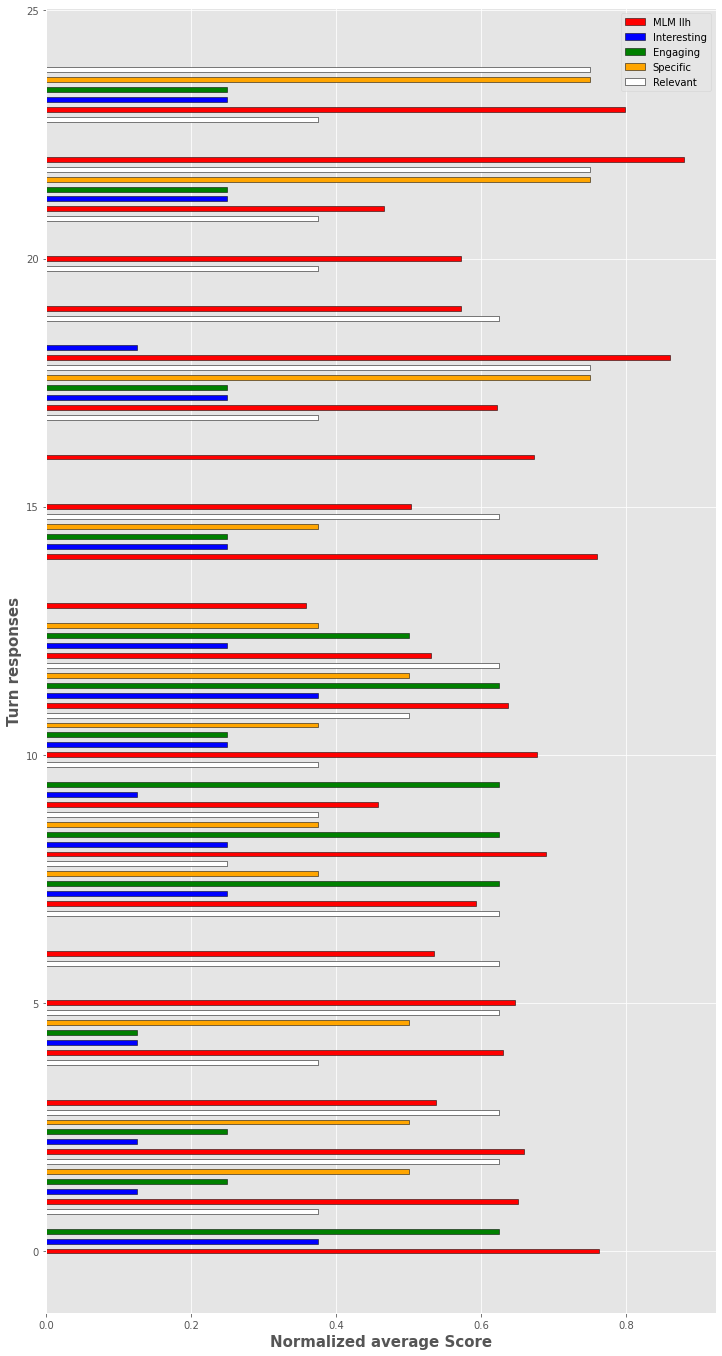

In [63]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

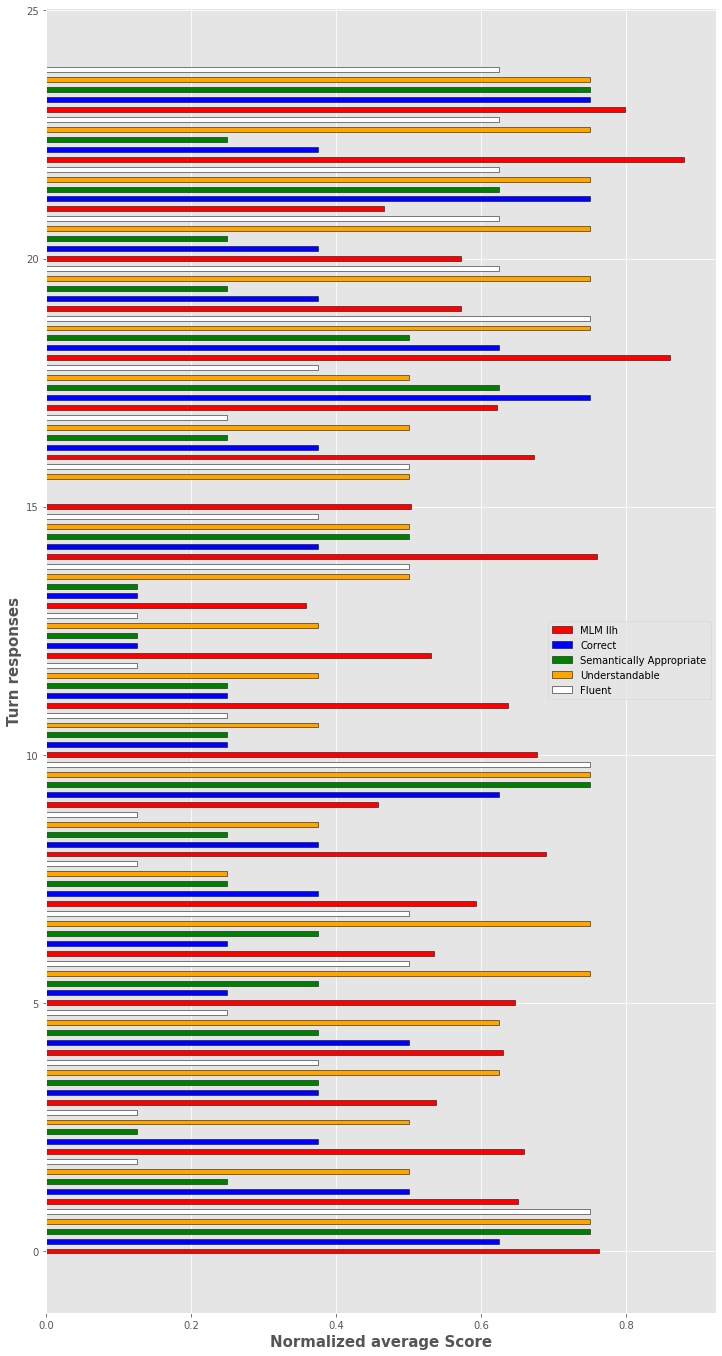

In [64]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [65]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLcontext

In [66]:
score_name_x = "USR DLcontext"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Piotr scenario 2.csv
24 {4: 0.996822, 6: 0.9976069, 8: 0.9964381, 10: 0.9950822, 12: 0.99756783, 14: 0.99698335, 16: 0.99693036, 18: 0.9968395, 20: 0.99765116, 25: 0.9965136, 27: 0.99758434, 29: 0.99740607, 31: 0.99762964, 33: 0.9976862, 35: 0.9971352, 37: 0.048813455, 39: 0.6536161, 41: 0.9974907, 43: 0.9977366, 45: 0.9976846, 47: 0.99747086, 49: 0.9977241, 51: 0.994106, 53: 0.99533015}
24 {4: 0.625, 6: 0.375, 8: 0.375, 10: 0.25, 12: 0.375, 14: 0.25, 16: 0.25, 18: 0.375, 20: 0.375, 25: 0.625, 27: 0.25, 29: 0.375, 31: 0.125, 33: 0.125, 35: 0.375, 37: 0.125, 39: 0.125, 41: 0.625, 43: 0.375, 45: 0.25, 47: 0.25, 49: 0.5, 51: 0.25, 53: 0.5}


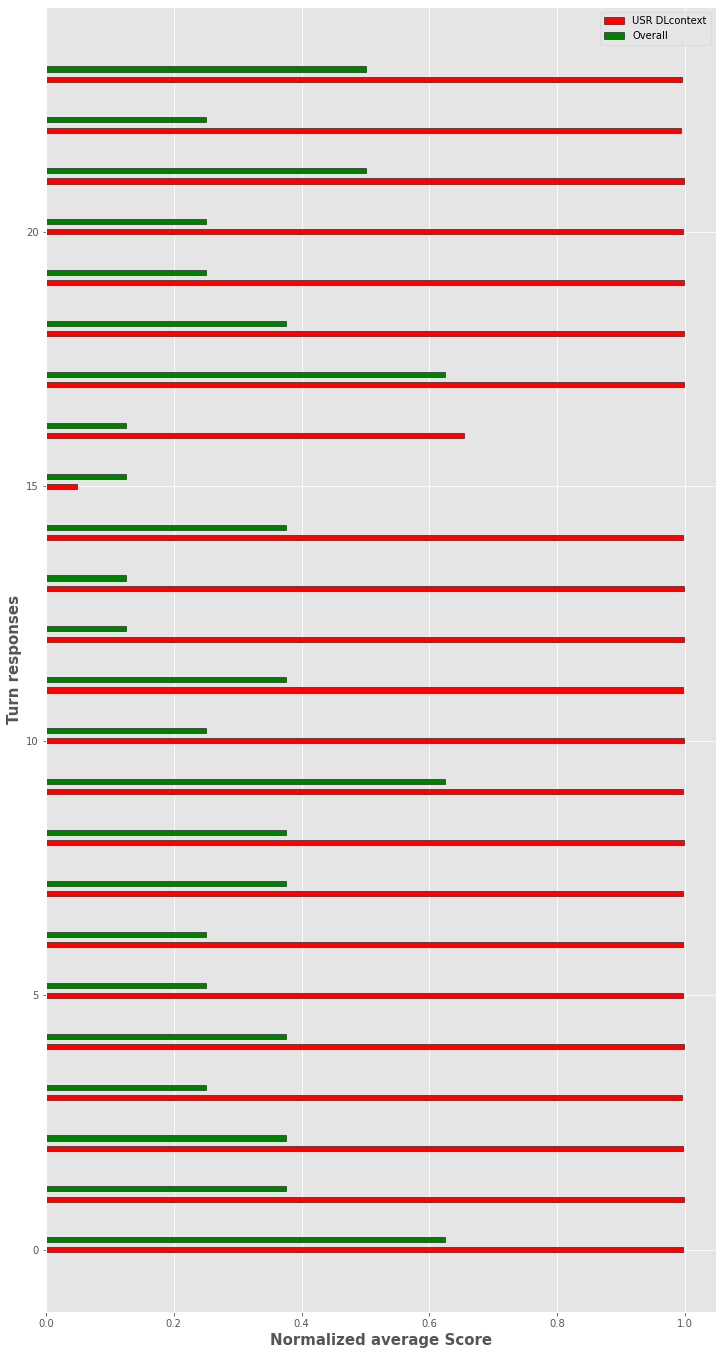

In [67]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

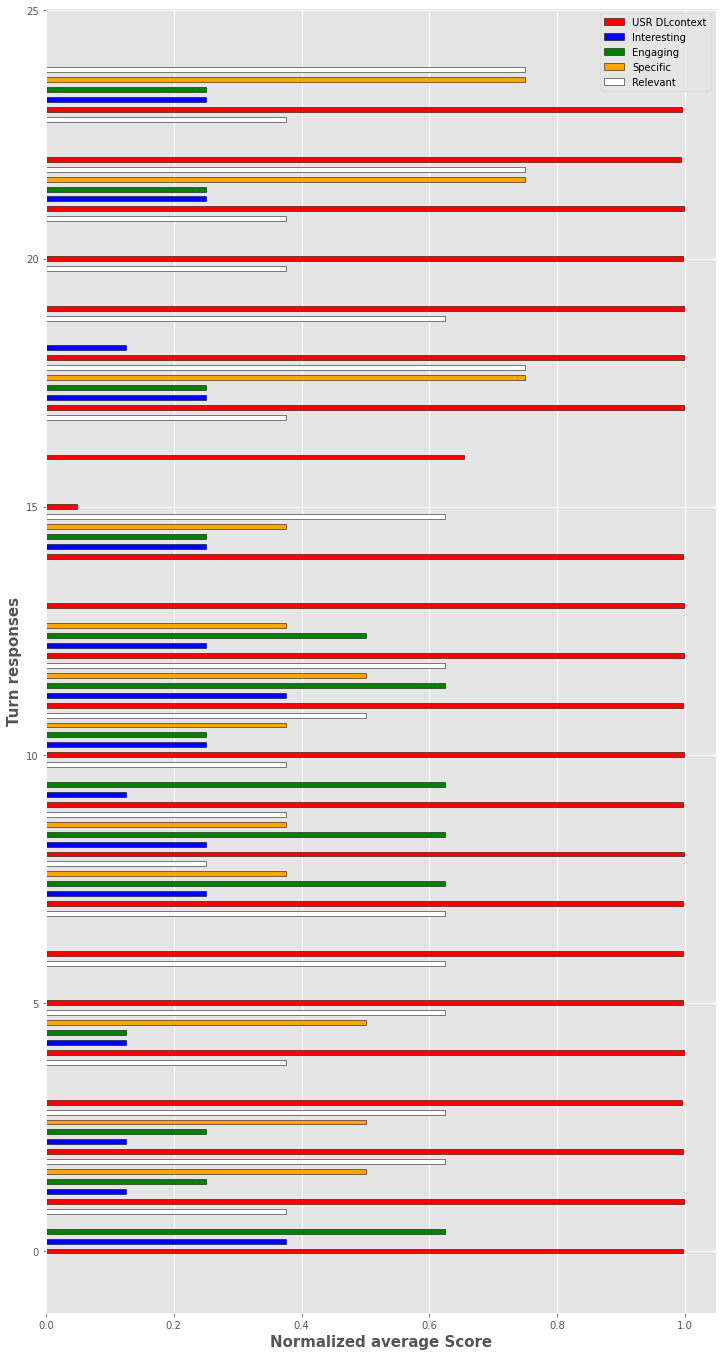

In [68]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

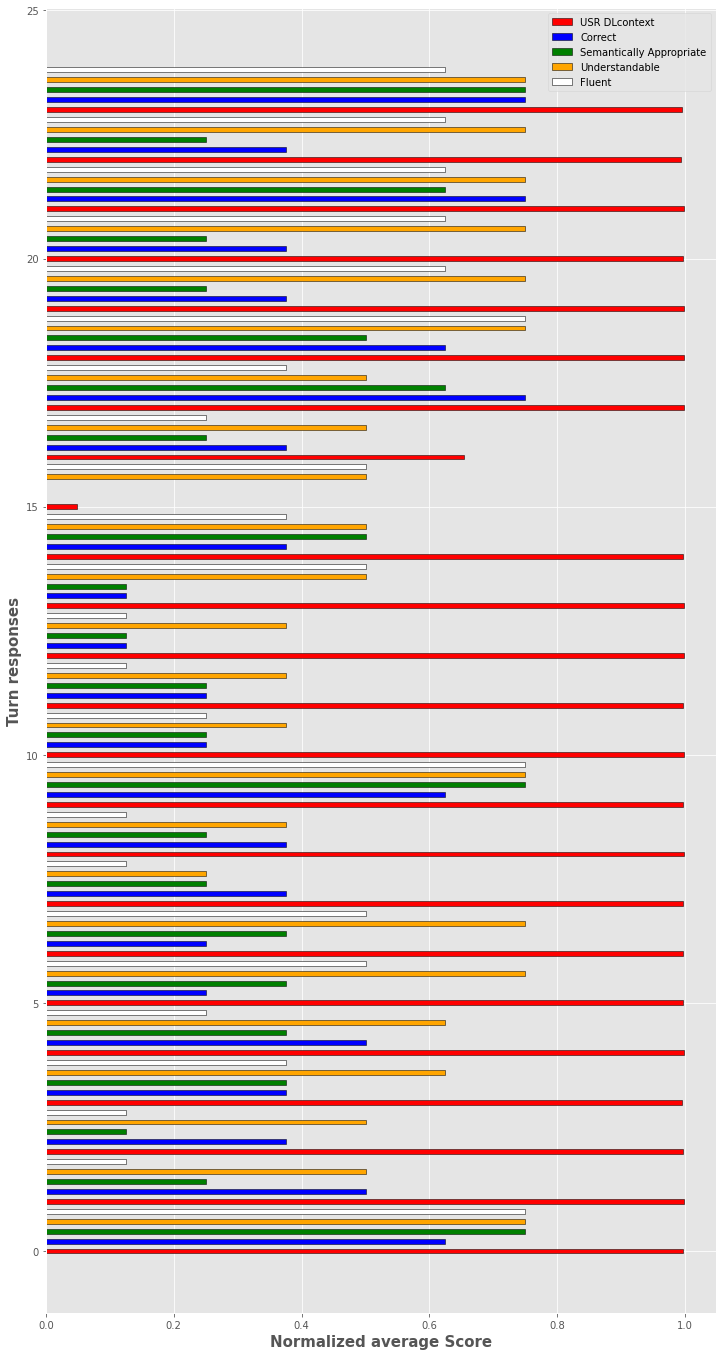

In [69]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [70]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLfact

In [71]:
score_name_x = "USR DLfact"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)



/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g2-jaap/scenario2/annotation Piotr scenario 2.csv
24 {4: 0.7543927, 6: 0.9969748, 8: 0.9970483, 10: 0.9968744, 12: 0.76634204, 14: 0.99703157, 16: 0.995611, 18: 0.9949875, 20: 0.99653333, 25: 0.9971902, 27: 0.9968189, 29: 0.99693435, 31: 0.9967776, 33: 0.99625534, 35: 0.9968018, 37: 0.71064746, 39: 0.9791677, 41: 0.99635106, 43: 0.9969856, 45: 0.99684817, 47: 0.9970719, 49: 0.9968559, 51: 0.9957514, 53: 0.82452494}
24 {4: 0.625, 6: 0.375, 8: 0.375, 10: 0.25, 12: 0.375, 14: 0.25, 16: 0.25, 18: 0.375, 20: 0.375, 25: 0.625, 27: 0.25, 29: 0.375, 31: 0.125, 33: 0.125, 35: 0.375, 37: 0.125, 39: 0.125, 41: 0.625, 43: 0.375, 45: 0.25, 47: 0.25, 49: 0.5, 51: 0.25, 53: 0.5}


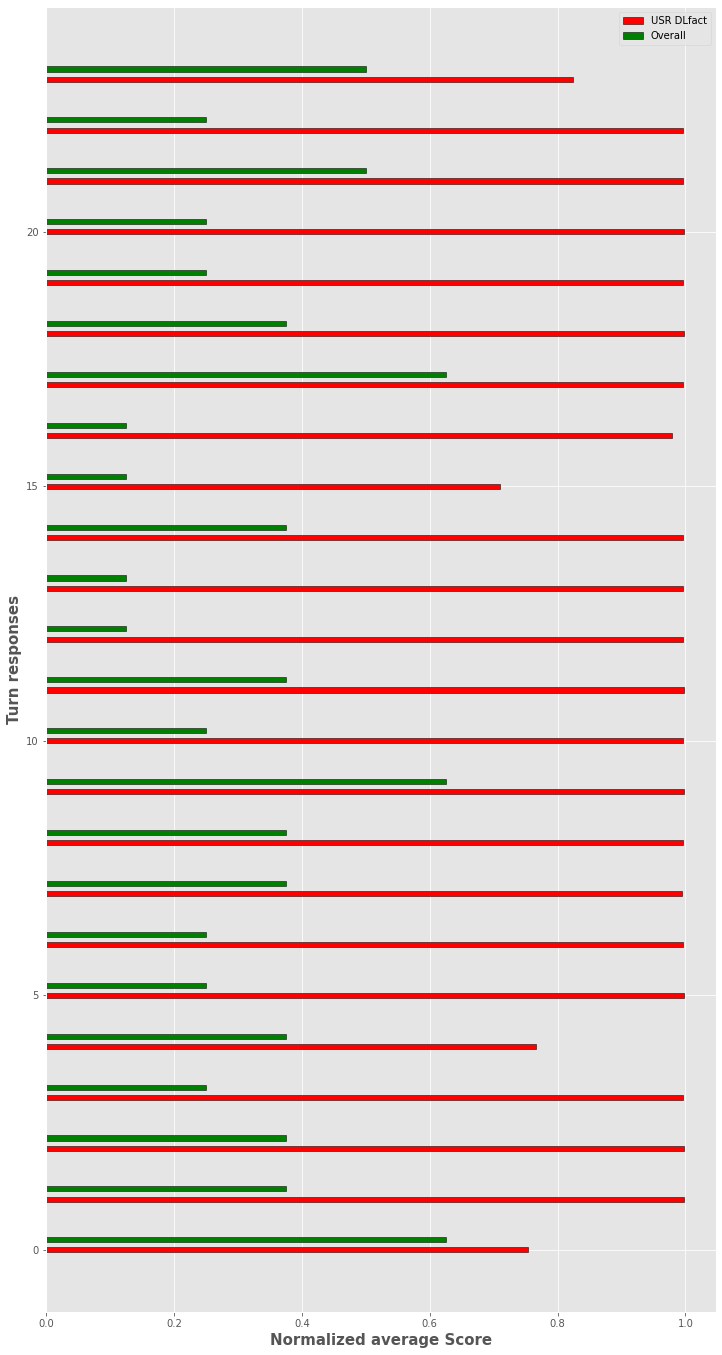

In [72]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

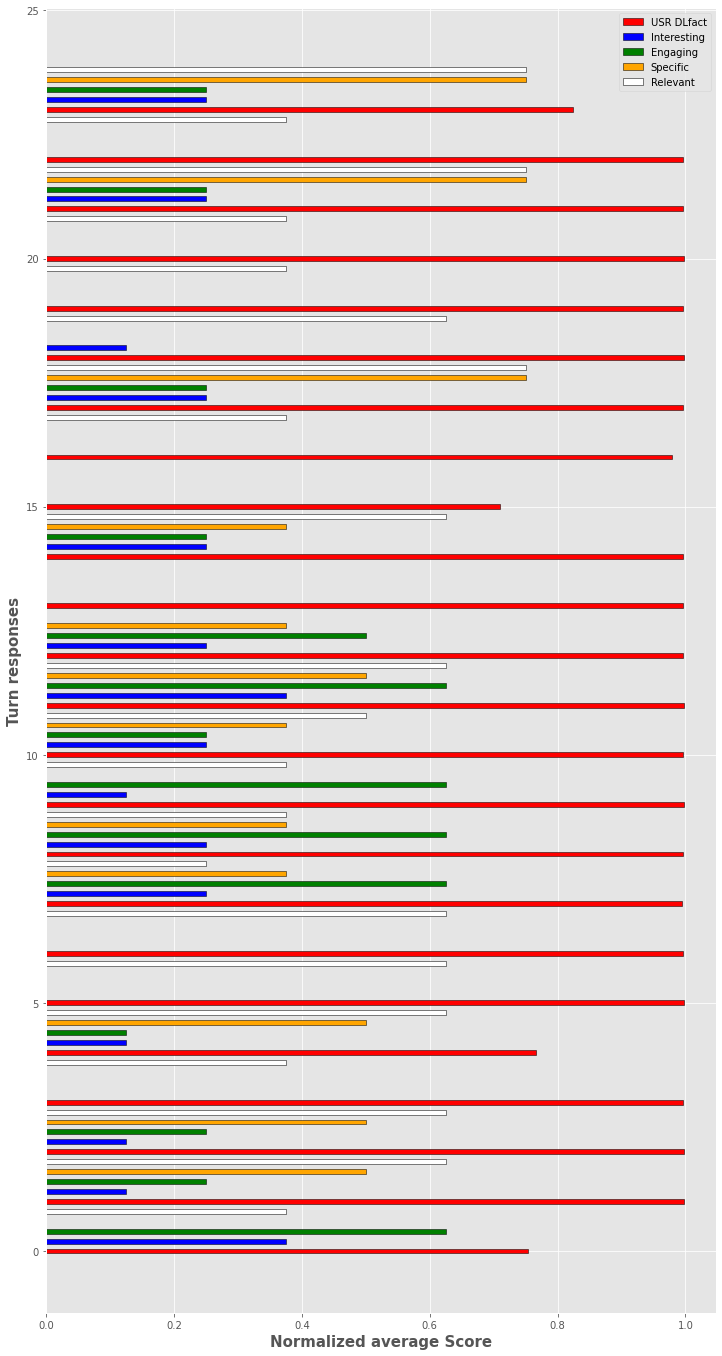

In [73]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

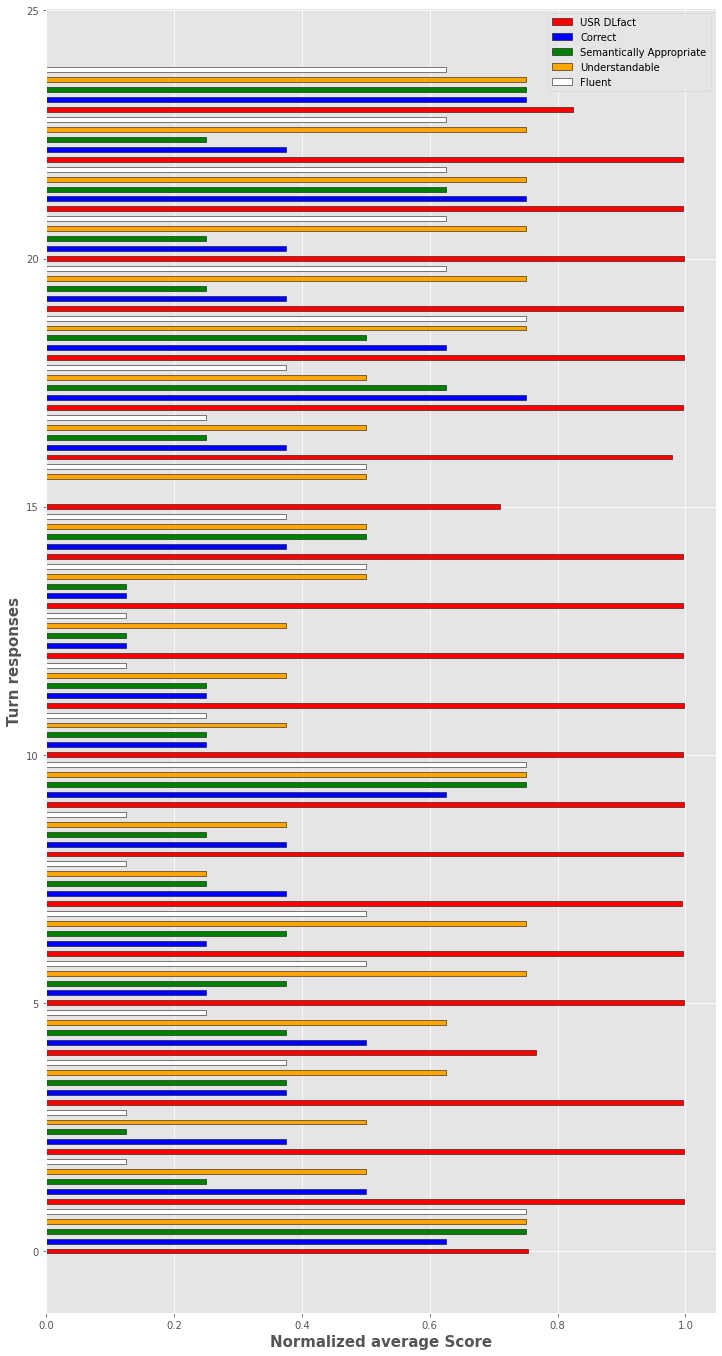

In [74]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [75]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

## End of notebook